# Build chunk-level training dataset from DuckDB + ChromaDB

1) Load chunks from DuckDB and flatten relevant fields
2) Load all embeddings from ChromaDB collection `mdc_training_data` (no batching)
3) Merge by `chunk_id`
4) Label RELEVANT (1) for chunks with ≥1 citation and their immediate neighbors; else NOT RELEVANT (0)
5) Drop metadata/non-numeric columns for modeling
6) Save to `../Data/train/train_data_chunks.csv`
7) Perform correlation analysis and simple visualizations (mirroring `training_input.ipynb`)


In [1]:
# Imports and setup
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import duckdb
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

# Local imports
from api.utils.duckdb_utils import DuckDBHelper
from src.helpers import initialize_logging

# Plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

# Logging
logger = initialize_logging("training_input_chunks")
print(f"✅ Imports complete. Project root: {project_root}")


2025-09-01 10:32:34,211 - src.helpers - INFO - Logging initialized for /Users/taishajoseph/Documents/Projects/MDC-Challenge-2025/logs/duckdb_utils.log
2025-09-01 10:32:34,211 - src.helpers - INFO - Logging initialized for /Users/taishajoseph/Documents/Projects/MDC-Challenge-2025/logs/duckdb_utils.log


✅ Imports complete. Project root: /Users/taishajoseph/Documents/Projects/MDC-Challenge-2025


In [2]:
# Configuration and clients
DB_PATH = "../artifacts/mdc_challenge.db"
CFG_PATH = os.path.join(project_root, "configs", "chunking.yaml")
COLLECTION_NAME = "mdc_training_data"
REPORT_DIR = Path("reports/training_analysis_chunks")
REPORT_DIR.mkdir(parents=True, exist_ok=True)

# Initialize DuckDB helper
db = DuckDBHelper(DB_PATH)

print("✅ Configured DB and report paths")


2025-09-01 10:32:34,415 - api.database.duckdb_schema - INFO - Starting DuckDB schema creation...
2025-09-01 10:32:34,415 - api.database.duckdb_schema - INFO - Starting DuckDB schema creation...
2025-09-01 10:32:34,415 - api.database.duckdb_schema - INFO - Starting DuckDB schema creation...
2025-09-01 10:32:34,494 - api.database.duckdb_schema - INFO - Creating documents table...
2025-09-01 10:32:34,494 - api.database.duckdb_schema - INFO - Creating documents table...
2025-09-01 10:32:34,494 - api.database.duckdb_schema - INFO - Creating documents table...
2025-09-01 10:32:34,506 - api.database.duckdb_schema - INFO - Documents table created successfully
2025-09-01 10:32:34,506 - api.database.duckdb_schema - INFO - Documents table created successfully
2025-09-01 10:32:34,506 - api.database.duckdb_schema - INFO - Documents table created successfully
2025-09-01 10:32:34,515 - api.database.duckdb_schema - INFO - Creating citations table...
2025-09-01 10:32:34,515 - api.database.duckdb_schema

✅ Configured DB and report paths


In [3]:
# Load chunks from DuckDB using Pydantic Chunk model (robust)
from src.models import Chunk

print("🔄 Loading chunks from DuckDB into Chunk objects...")
result = db.engine.execute("SELECT * FROM chunks")
rows = result.fetchall()
cols = [desc[0] for desc in result.description]

chunks = []
for row in rows:
    row_dict = dict(zip(cols, row))
    try:
        chunks.append(Chunk.from_duckdb_row(row_dict))
    except Exception as e:
        # Skip rows that fail to hydrate
        continue

# Build a DataFrame from Chunk objects
records = []
for ch in chunks:
    ce_list = ch.chunk_metadata.citation_entities or []
    ce_flat = [ce.to_string() for ce in ce_list]
    records.append({
        "chunk_id": ch.chunk_id,
        "document_id": ch.document_id,
        "chunk_text": ch.text,
        "score": ch.score,
        "token_count": ch.chunk_metadata.token_count,
        "previous_chunk_id": ch.chunk_metadata.previous_chunk_id or None,
        "next_chunk_id": ch.chunk_metadata.next_chunk_id or None,
        "citation_entities": ce_flat,
        "citation_entities_len": len(ce_list),
    })

df_chunks = pd.DataFrame.from_records(records)
# Convenience flag
df_chunks["has_citation"] = df_chunks["citation_entities_len"] > 0

print(f"✅ Loaded {len(df_chunks):,} chunks (objects)")
display(df_chunks.head())


🔄 Loading chunks from DuckDB into Chunk objects...
✅ Loaded 7,736 chunks (objects)


,chunk_id,document_id,chunk_text,score,token_count,previous_chunk_id,next_chunk_id,citation_entities,citation_entities_len,has_citation
0,10.1093_beheco_arz101_0,10.1093_beheco_arz101,Behavioral Ecology The official journal of the...,None,495,None,10.1093_beheco_arz101_1,[],0,False
1,10.1093_beheco_arz101_1,10.1093_beheco_arz101,water temperature affect brooding traits that ...,None,403,10.1093_beheco_arz101_0,10.1093_beheco_arz101_2,[],0,False
2,10.1093_beheco_arz101_2,10.1093_beheco_arz101,optimize the trade-off between investment in a...,None,477,10.1093_beheco_arz101_1,10.1093_beheco_arz101_3,[],0,False
3,10.1093_beheco_arz101_3,10.1093_beheco_arz101,parental care quality can shed important light...,None,490,10.1093_beheco_arz101_2,10.1093_beheco_arz101_4,[],0,False
4,10.1093_beheco_arz101_4,10.1093_beheco_arz101,"better) as small eggs, even under low oxygen c...",None,454,10.1093_beheco_arz101_3,10.1093_beheco_arz101_5,[],0,False


In [4]:
# Build target labels: RELEVANT if citation_entities_len > 0, plus immediate neighbors
print("🔄 Building RELEVANT labels (seeds + neighbors)...")

seed_ids = set(df_chunks.loc[df_chunks["citation_entities_len"] > 0, "chunk_id"])  # stricter seed rule

prev_neighbors = set(
    df_chunks.loc[df_chunks["chunk_id"].isin(seed_ids), "previous_chunk_id"].dropna().tolist()
)
next_neighbors = set(
    df_chunks.loc[df_chunks["chunk_id"].isin(seed_ids), "next_chunk_id"].dropna().tolist()
)
neighbor_ids = prev_neighbors.union(next_neighbors)

relevant_ids = seed_ids.union(neighbor_ids)

# Assign binary target and string label
df_chunks["target"] = df_chunks["chunk_id"].isin(relevant_ids).astype(int)
df_chunks["target_str"] = np.where(df_chunks["target"] == 1, "RELEVANT", "NOT RELEVANT")

print(
    f"✅ Seeds: {len(seed_ids):,} | Neighbors: {len(neighbor_ids):,} | Total RELEVANT: {df_chunks['target'].sum():,}"
)


🔄 Building RELEVANT labels (seeds + neighbors)...
✅ Seeds: 442 | Neighbors: 806 | Total RELEVANT: 1,050


In [5]:
# Generate embeddings offline for all chunks (no Chroma)
print("🔄 Generating embeddings locally for all chunks...")

from api.services.embeddings_services import embed_text
model_path = os.path.join(project_root, "offline_models")

texts = df_chunks["chunk_text"].fillna("").tolist()
print(f"▸ Embedding {len(texts):,} chunks using model at: {model_path}")

# Single batched call; do NOT loop per-chunk
embeddings = embed_text(texts=texts, model_name=model_path, batch_size=100)

# Validate shape and map back to rows
if isinstance(embeddings, list):
    embeddings = np.array(embeddings)
if embeddings is None or embeddings.ndim != 2:
    raise RuntimeError(f"Unexpected embedding shape: {getattr(embeddings, 'shape', None)}")
n_rows, n_dims = embeddings.shape
if n_rows != len(texts):
    raise RuntimeError(f"Row count mismatch: embeddings={n_rows}, texts={len(texts)}")
print(f"✅ Embeddings shape: {embeddings.shape}")

# Build embeddings DataFrame aligned to df_chunks order
emb_cols = [f"emb_{i}" for i in range(n_dims)]
emb_df = pd.DataFrame(embeddings, columns=emb_cols)
emb_df.insert(0, "chunk_id", df_chunks["chunk_id"].values)


🔄 Generating embeddings locally for all chunks...


/Users/taishajoseph/miniconda3/envs/mdc-challenge-2025/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-01 10:33:15,839 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-09-01 10:33:15,839 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-09-01 10:33:15,839 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-09-01 10:33:15,839 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-09-01 10:33:15,839 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-09-01 10:33:15,839 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-09-01 10:33:15,848 - sentence_transformers.SentenceTransformer - INFO 

▸ Embedding 7,736 chunks using model at: /Users/taishajoseph/Documents/Projects/MDC-Challenge-2025/offline_models
Executing embed_text...


Batches: 100%|██████████| 78/78 [09:14<00:00,  7.10s/it]


Function embed_text took 569.9814 seconds to complete.
✅ Embeddings shape: (7736, 384)


In [6]:
# Merge embeddings with chunks, keep IDs and labels
print("🔄 Merging embeddings with chunk metadata (left join to preserve all chunks)...")

df_merged = df_chunks.merge(emb_df, on="chunk_id", how="left")
print(f"✅ Merged rows: {len(df_merged):,}; columns: {len(df_merged.columns)}")
print(f"📌 Chunks missing embeddings: {(df_merged[emb_cols].isna().all(axis=1)).sum()}")
display(df_merged.head())


🔄 Merging embeddings with chunk metadata (left join to preserve all chunks)...
✅ Merged rows: 7,736; columns: 396
📌 Chunks missing embeddings: 0


,chunk_id,document_id,chunk_text,score,token_count,previous_chunk_id,next_chunk_id,citation_entities,citation_entities_len,has_citation,...,emb_374,emb_375,emb_376,emb_377,emb_378,emb_379,emb_380,emb_381,emb_382,emb_383
0,10.1093_beheco_arz101_0,10.1093_beheco_arz101,Behavioral Ecology The official journal of the...,None,495,None,10.1093_beheco_arz101_1,[],0,False,...,-0.015458,0.023589,-0.032979,-0.037276,-0.005317,0.054605,0.026833,-0.019565,0.098890,0.055512
1,10.1093_beheco_arz101_1,10.1093_beheco_arz101,water temperature affect brooding traits that ...,None,403,10.1093_beheco_arz101_0,10.1093_beheco_arz101_2,[],0,False,...,-0.005484,0.024652,0.004320,-0.028463,0.016289,0.062229,0.005102,-0.029444,0.099293,0.035085
2,10.1093_beheco_arz101_2,10.1093_beheco_arz101,optimize the trade-off between investment in a...,None,477,10.1093_beheco_arz101_1,10.1093_beheco_arz101_3,[],0,False,...,-0.021554,0.055830,-0.010331,0.030738,0.052802,0.080657,0.007860,-0.060096,0.083487,0.047805
3,10.1093_beheco_arz101_3,10.1093_beheco_arz101,parental care quality can shed important light...,None,490,10.1093_beheco_arz101_2,10.1093_beheco_arz101_4,[],0,False,...,-0.008698,0.036334,0.005779,-0.037128,0.034317,0.100105,-0.007818,-0.001108,0.115332,0.107688
4,10.1093_beheco_arz101_4,10.1093_beheco_arz101,"better) as small eggs, even under low oxygen c...",None,454,10.1093_beheco_arz101_3,10.1093_beheco_arz101_5,[],0,False,...,-0.033520,0.051418,0.043521,-0.032925,0.055606,0.084604,-0.000608,-0.036608,0.108437,0.083489


In [7]:
# Drop metadata/non-numeric columns; keep IDs and targets; save CSV
print("🔄 Preparing features and saving dataset...")

# Identify embedding columns
emb_cols = [c for c in df_merged.columns if c.startswith("emb_")]

# Columns to drop (metadata / non-numeric)
drop_cols = [
    "chunk_text",
    "citation_entities",
    "has_citation",
]

# Build final dataset
keep_cols = ["chunk_id", "document_id", "token_count", "target", "target_str"] + emb_cols
keep_cols = [c for c in keep_cols if c in df_merged.columns]

# Apply drops then select
_df = df_merged.drop(columns=[c for c in drop_cols if c in df_merged.columns])
df_features = _df[keep_cols].copy()

# Sanity: print pre vs post counts
print(f"All chunks → RELEVANT: {int(df_chunks['target'].sum()):,}")
print(f"With embeddings → RELEVANT: {int(df_merged['target'].sum()):,}")
print(f"Dropped RELEVANT due to missing embeddings: {int(df_chunks['target'].sum() - df_merged['target'].sum()):,}")

# Save to new filename
out_path = "../Data/train/train_data_chunks.csv"
df_features.to_csv(out_path, index=False)
print(f"✅ Training data saved to {out_path}")

display(df_features.head())

🔄 Preparing features and saving dataset...
All chunks → RELEVANT: 1,050
With embeddings → RELEVANT: 1,050
Dropped RELEVANT due to missing embeddings: 0
✅ Training data saved to ../Data/train/train_data_chunks.csv


,chunk_id,document_id,token_count,target,target_str,emb_0,emb_1,emb_2,emb_3,emb_4,...,emb_374,emb_375,emb_376,emb_377,emb_378,emb_379,emb_380,emb_381,emb_382,emb_383
0,10.1093_beheco_arz101_0,10.1093_beheco_arz101,495,0,NOT RELEVANT,0.015713,-0.009378,0.020453,0.024954,0.017898,...,-0.015458,0.023589,-0.032979,-0.037276,-0.005317,0.054605,0.026833,-0.019565,0.098890,0.055512
1,10.1093_beheco_arz101_1,10.1093_beheco_arz101,403,0,NOT RELEVANT,-0.015680,0.006466,0.015703,0.030072,0.044212,...,-0.005484,0.024652,0.004320,-0.028463,0.016289,0.062229,0.005102,-0.029444,0.099293,0.035085
2,10.1093_beheco_arz101_2,10.1093_beheco_arz101,477,0,NOT RELEVANT,-0.007936,-0.007952,-0.004148,0.034437,0.008208,...,-0.021554,0.055830,-0.010331,0.030738,0.052802,0.080657,0.007860,-0.060096,0.083487,0.047805
3,10.1093_beheco_arz101_3,10.1093_beheco_arz101,490,0,NOT RELEVANT,0.014775,-0.014930,0.028272,0.025603,0.000877,...,-0.008698,0.036334,0.005779,-0.037128,0.034317,0.100105,-0.007818,-0.001108,0.115332,0.107688
4,10.1093_beheco_arz101_4,10.1093_beheco_arz101,454,0,NOT RELEVANT,-0.000533,-0.041749,0.001220,0.048582,-0.003726,...,-0.033520,0.051418,0.043521,-0.032925,0.055606,0.084604,-0.000608,-0.036608,0.108437,0.083489


In [8]:
# Correlation analysis and simple visualizations (chunks)
print("🔄 Calculating Pearson and Spearman correlations...")

# Numeric feature columns: embeddings + numeric metadata
feature_cols = [c for c in df_features.columns if c.startswith("emb_")] + [c for c in ["token_count", "citation_entities_len"] if c in df_features.columns]

# Clean dataset for correlation
corr_df = df_features[feature_cols + ["target"]].dropna()
print(f"📊 Clean dataset shape: {corr_df.shape}")

# Pearson correlations
pearson = []
for f in feature_cols:
    r, p = stats.pearsonr(corr_df[f], corr_df["target"])  # type: ignore
    pearson.append({"feature": f, "correlation": r, "p_value": p, "abs_correlation": abs(r)})

df_pearson = pd.DataFrame(pearson).sort_values("abs_correlation", ascending=False)
print("✅ Pearson correlations computed")

display(df_pearson.head(10))


🔄 Calculating Pearson and Spearman correlations...
📊 Clean dataset shape: (7736, 386)
✅ Pearson correlations computed


,feature,correlation,p_value,abs_correlation
384,token_count,0.190199,6.266539e-64,0.190199
319,emb_319,0.105428,1.440402e-20,0.105428
151,emb_151,0.094185,1.031735e-16,0.094185
132,emb_132,-0.090104,2.022470e-15,0.090104
375,emb_375,0.089808,2.497342e-15,0.089808
323,emb_323,0.088426,6.624286e-15,0.088426
92,emb_92,0.084104,1.269964e-13,0.084104
205,emb_205,-0.083828,1.525778e-13,0.083828
318,emb_318,0.082444,3.798973e-13,0.082444
10,emb_10,-0.082002,5.068100e-13,0.082002


🔄 Calculating Spearman correlations and creating simple plots...
✅ Spearman correlations computed


,feature,correlation,p_value,abs_correlation
384,token_count,0.181822,1.728125e-58,0.181822
319,emb_319,0.108425,1.142507e-21,0.108425
151,emb_151,0.100054,1.135572e-18,0.100054
323,emb_323,0.087197,1.556713e-14,0.087197
132,emb_132,-0.086990,1.796120e-14,0.086990
375,emb_375,0.083787,1.567917e-13,0.083787
49,emb_49,-0.083690,1.672945e-13,0.083690
92,emb_92,0.081902,5.407644e-13,0.081902
318,emb_318,0.079773,2.117699e-12,0.079773
10,emb_10,-0.079710,2.204700e-12,0.079710


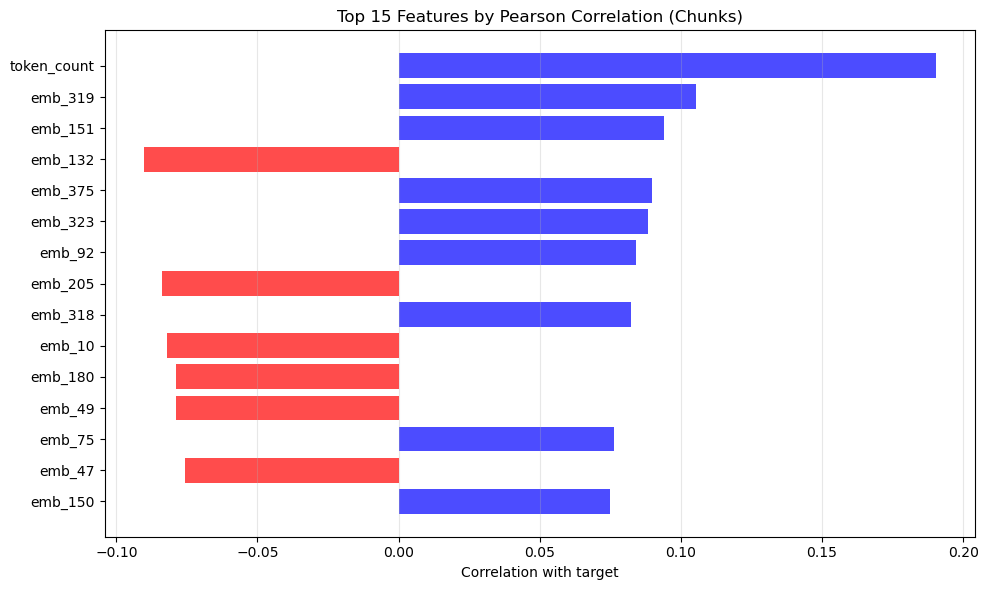

In [9]:
# Spearman correlations and simple plots
print("🔄 Calculating Spearman correlations and creating simple plots...")

# Spearman
spearman = []
for f in feature_cols:
    rho, p = stats.spearmanr(corr_df[f], corr_df["target"])  # type: ignore
    spearman.append({"feature": f, "correlation": rho, "p_value": p, "abs_correlation": abs(rho)})

df_spearman = pd.DataFrame(spearman).sort_values("abs_correlation", ascending=False)
print("✅ Spearman correlations computed")

display(df_spearman.head(10))

# Simple bar plot of top-15 Pearson features
top15 = df_pearson.head(15)
plt.figure(figsize=(10, 6))
colors = ["red" if x < 0 else "blue" for x in top15["correlation"]]
plt.barh(top15["feature"], top15["correlation"], color=colors, alpha=0.7)
plt.gca().invert_yaxis()
plt.title("Top 15 Features by Pearson Correlation (Chunks)")
plt.xlabel("Correlation with target")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


In [10]:
# Save correlation outputs to adjusted report directory
from datetime import datetime
print("🔄 Saving correlation outputs...")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
pearson_file = REPORT_DIR / f"pearson_correlations_chunks_{timestamp}.csv"
spearman_file = REPORT_DIR / f"spearman_correlations_chunks_{timestamp}.csv"

df_pearson.to_csv(pearson_file, index=False)
df_spearman.to_csv(spearman_file, index=False)
print(f"✅ Saved: {pearson_file}\n✅ Saved: {spearman_file}")


🔄 Saving correlation outputs...
✅ Saved: reports/training_analysis_chunks/pearson_correlations_chunks_20250901_104256.csv
✅ Saved: reports/training_analysis_chunks/spearman_correlations_chunks_20250901_104256.csv


In [11]:
# Summary and close
print("📊 CHUNK TRAINING INPUT SUMMARY")
print("=" * 50)

print(f"Samples: {len(df_features):,}")
print(f"Feature columns (embeddings + numeric): {len(feature_cols)}")
print(f"RELEVANT (1): {int((df_features['target']==1).sum()):,}")
print(f"NOT RELEVANT (0): {int((df_features['target']==0).sum()):,}")

# Close DB connection
db.close()
print("🔒 Database connection closed.")


📊 CHUNK TRAINING INPUT SUMMARY
Samples: 7,736
Feature columns (embeddings + numeric): 385
RELEVANT (1): 1,050
NOT RELEVANT (0): 6,686
🔒 Database connection closed.
